In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib as plt
import seaborn as sns
import tsfresh
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
ballotsdf = pd.read_csv('ballots_party_2019.csv')
partiesdf =  pd.read_csv('parties_Bremen_2019.csv').append({'party_id': 1500, 'shortname': 'The X-party', 'name': 'Some party that failed even to get listed properly'},ignore_index=True)
display(partiesdf)
display(ballotsdf)

In [3]:
#replacing NaN with 0 - it seems to be quite natural
for column in ballotsdf:
    ballotsdf[column]=ballotsdf[column].apply(lambda x: 0 if np.isnan(x)==True else x)

In [133]:
#now we have to merge the same ballots where the order is the only different thing
def unique_ballots(df):
    combdf = pd.DataFrame({'Counter':[], 'Quantity':[]})
    for i in range(len(df)):
        counter = Counter(df.iloc[i, :5])
        if len(combdf[combdf.Counter == counter])==0:
            combdf = combdf.append({'Counter':counter, 'Quantity':df.iloc[i, 5]}, ignore_index=True)
        else:
            combdf.loc[combdf[combdf.Counter==counter].index, 'Quantity']+=df.iloc[i, 5]
    combdf.Counter = combdf.Counter.apply(lambda x: sum([[value]*key for value, key in zip(x.keys(), x.values())], []))
    vote_1 = combdf.Counter.apply(lambda x: x[0])
    vote_2 = combdf.Counter.apply(lambda x: x[1])
    vote_3 = combdf.Counter.apply(lambda x: x[2])
    vote_4 = combdf.Counter.apply(lambda x: x[3])
    vote_5 = combdf.Counter.apply(lambda x: x[4])
    newdf=pd.DataFrame({'vote_1': vote_1, 'vote_2': vote_2, 'vote_3': vote_3, 'vote_4': vote_4, 'vote_5':vote_5, 'quantity': combdf.Quantity})
    return newdf

unique_ballots_df = unique_ballots(ballotsdf).reset_index(drop=True)

In [ ]:
#now we need to introduce some additional labelling of the data
def general_labelling(ballot):
    '''Maps the ballot to the parties or states the ballot is empty indicating all the percentages'''
    ranking = np.array(Counter(ballot).most_common())
    vote_list = []
    for party_votes in ranking:
        try:
            vote = (int(party_votes[1]*20), partiesdf[partiesdf.party_id==party_votes[0]].iloc[:, 1].reset_index(drop=True)[0])
            vote_list.append(vote)
        except KeyError:
            vote = (int(party_votes[1]*20), 'empty')
            vote_list.append(vote)      
    label = ';'.join([f'{vote[0]} percent for {vote[1]}' for vote in vote_list])
    return label
unique_ballots_df['general_label'] = unique_ballots_df.iloc[:, :5].apply(general_labelling, axis=1)

In [135]:
#and a label concerning emptiness
def empty_labelling(description):
    '''Auxiliary label indicating emptiness percentage'''
    if 'empty' in description:
        split = description.split(';')
        if len(split)>1:
            label = int(list(filter(lambda string: 'empty' in string, split))[0][:2])
        else:
            label=100
    else:
        label = 0
    return label    
unique_ballots_df['emptiness_percentage'] = unique_ballots_df['general_label'].apply(empty_labelling)

In [167]:
#and a label concerning the dominant party
def dominant_party(description):
    '''Auxiliary label giving the name of the dominant party'''
    split = description.split(';')
    if len(split)==1:
        if 'empty' in description:
            label = 'no dominant party'
        else:   
            label = split[0].split('for ')[1]
    else:
        if split[0][:2]==split[1][:2]:
            label = 'no dominant party'
        else:
            label = split[0].split('for ')[1]
    return label
unique_ballots_df['dominant_party'] = unique_ballots_df['general_label'].apply(dominant_party)

In [156]:
#and a label concerning parties involved
def parties_involved(description):
    '''Auxiliary label giving name of the parties voted for in the ballot'''
    split = description.split(';')
    if 'empty' in description and len(split)==1:
        label = 'no party'
    else:
        parties_percentages = list(filter(lambda string: 'empty' not in string, split))
        party_list = [parties_percentage.split('for ')[1] for parties_percentage in parties_percentages]
        party_list = sorted(party_list, reverse=True)
        label = ';'.join(party_list)
    return label
unique_ballots_df['parties_involved'] = unique_ballots_df['general_label'].apply(parties_involved)

In [224]:
#and the labels for political spectrum
left = ['DIE LINKE', 'GRÜNE', 'PIRATEN', 'Die PARTEI', 'BGE', 'V-Partei³', 'Die Humanisten']
right = ['AfD', 'BIW']
center= ['CDU', 'FDP', 'FREIE WÄHLER', 'MENSCHLICHE WELT', 'SPD']

def spectrum(ballot):
    '''Auxiliary label standing for the ballot's location on a priori political spectrum'''
    
    def attribution(party_name):
        '''Auxiliary function to identify the party postion on the spectrum given its name'''
        if party_name in left:
            position = 'left'
        elif party_name in right:
            position = 'right'
        elif party_name in center:
            position = 'center'
        elif party_name == 'The X-party':
            position='TBD'
        elif party_name == 'empty':
            position= 'null'
        return position

    ranking = np.array(Counter(ballot).most_common())
    vote_list = []
    for party_votes in ranking:
        try:
            vote = (int(party_votes[1]*20), partiesdf[partiesdf.party_id==party_votes[0]].iloc[:, 1].reset_index(drop=True)[0])
            vote_list.append(vote)
        except KeyError:
            vote = (int(party_votes[1]*20), 'empty')
            vote_list.append(vote)
    orientations =  list(map(attribution, [vote[1] for vote in vote_list]))
    positions = [(orientation, vote[0]) for orientation, vote in zip(orientations, vote_list)]
    if len(positions)==1:
        label=f'100 percent {positions[0][0]}'
    else:
        results = [(orientation, sum([tuple[1] for tuple in list(filter(lambda position: position[0]==orientation, positions))])) for orientation in list(Counter(orientations))]
        label=';'.join([f'{result[1]} percent {result[0]}' for result in sorted(results)])
    return label

unique_ballots_df['spectrum'] = unique_ballots_df.iloc[:, :5].apply(spectrum, axis=1)

In [226]:
#here we make dummy variables for each party
strdf = pd.DataFrame()
for col in unique_ballots_df:
    strdf[col] = unique_ballots_df[col].apply(str)
#drop_first=True?
strdf = pd.get_dummies(strdf, columns = ['vote_1', 'vote_2', 'vote_3', 'vote_4', 'vote_5'])

In [229]:
def new_dim_to_df(transformed):
    '''Receives a transformed values of ballots and returns a dataframe adding their quantity and labels from the initial df'''
    df = pd.DataFrame()
    for i in range(len(transformed[0])):
        df[f'Component_{i+1}'] = transformed[:, i]
    df = pd.concat([df, strdf.iloc[:, :6]], axis=1)
    return df

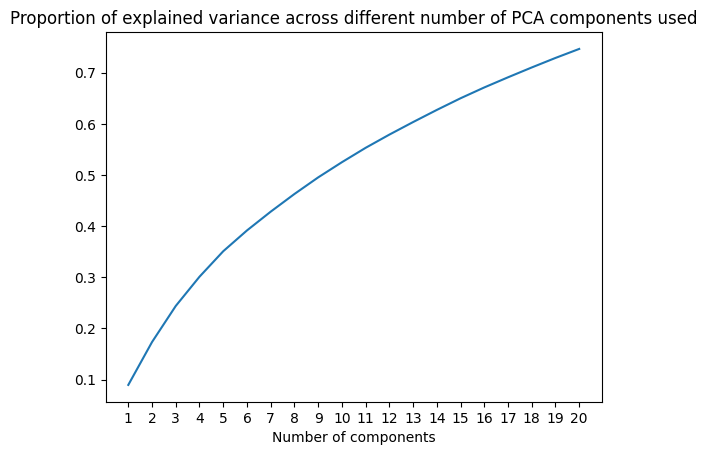

In [44]:
from sklearn.decomposition import PCA
var_explained = []
for i in range(1, 21):
    pca = PCA(n_components=i).fit(strdf.iloc[:, 6:])
    var_explained.append(sum(pca.explained_variance_ratio_))
plt.plot(var_explained)
plt.xticks(ticks=list(range(0, 20)), labels=list(range(1, 21)))
plt.xlabel('Number of components')
plt.title('Proportion of explained variance across different number of PCA components used')
plt.show()

In [ ]:
#let us pick 10 components: the ratio seems to go down after this mark, and at the same time it explains over 50% of variance
pca = PCA(n_components=10, random_state=1).fit(X=strdf.iloc[:, 6:])
PCA_df = new_dim_to_df(transformed = pca.transform(X=strdf.iloc[:, 6:]))
PCA_df

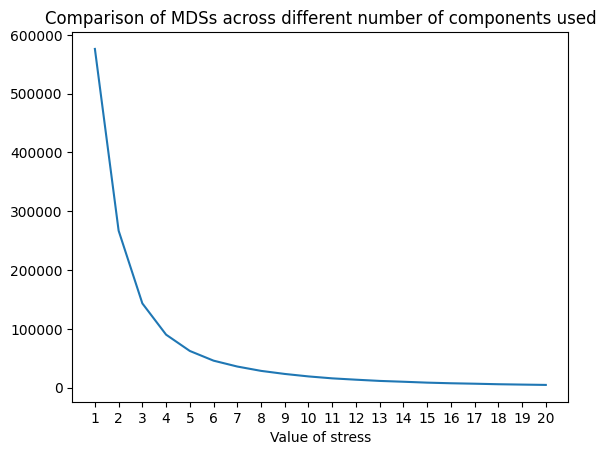

In [46]:
from sklearn.manifold import MDS
stress = []
for i in range(1, 21):
    embedding = MDS(n_components=i, random_state=1)
    embedding.fit_transform(strdf.iloc[:, 6:])
    stress.append(embedding.stress_)
plt.plot(stress)
plt.xticks(ticks=list(range(0, 20)), labels=list(range(1, 21)))
plt.xlabel('Value of stress')
plt.title('Comparison of MDSs across different number of components used')
plt.show()

In [ ]:
#let us pick 5 components since there is not much of improvement after this mark
embedding = MDS(n_components=5, random_state=1)
MDS_df = new_dim_to_df(transformed = embedding.fit_transform(strdf.iloc[:, 6:]))
MDS_df

In [5]:
#converting into the df with single ballots
def single_ballots(df):
    uniform_ballots = []
    for i in range(len(df)):
        row = df.iloc[i, :5]
        multiplicator = int(df.iloc[i, 5])
        uniform_ballots.append(pd.concat([pd.DataFrame(row).transpose() for i in range(multiplicator)], ignore_index=True))
    converted_df = pd.concat(uniform_ballots, ignore_index=True)
    return converted_df

df = single_ballots(unique_ballots_df).reset_index(drop=True)
df

,vote_1,vote_2,vote_3,vote_4,vote_5
0,100.0,100.0,100.0,100.0,100.0
1,100.0,100.0,100.0,100.0,100.0
2,100.0,100.0,100.0,100.0,100.0
3,100.0,100.0,100.0,100.0,100.0
4,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...
253151,0.0,0.0,0.0,0.0,0.0
253152,0.0,0.0,0.0,0.0,0.0
253153,0.0,0.0,0.0,0.0,0.0
253154,0.0,0.0,0.0,0.0,0.0


In [54]:
# is it needed?
from tsfresh import extract_features
x = extract_features(df, column_id='index')

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]